In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import cPickle as pickle
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/RickS/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### LOAD DF


In [2]:
movie_df = None
with open('Pickle_Files/movie_df.pkl', 'rb') as f:
    movie_df = pickle.load(f)

    

In [8]:
gnr_dummies = None
with open('Pickle_Files/gnr_dummies.pkl', 'rb') as f:
    gnr_dummies = pickle.load(f)

In [9]:
for c in movie_df.columns: print c
print
print movie_df.shape
# Drop Studio
movie_df.drop('Studio', axis =1 , inplace = True)

Title
Release_Date
Release_Month
Genres
Actors
Directors
Studio
Runtime
Foreign_Gross
Domestic_Gross
Total_Gross
Opening_Week_Gross
Opening_Num_Theaters
Total_Theaters
Male_Score
Female_Score
Total_Actor_Score
Director_Score
Production_Budget

(2209, 19)


In [10]:
movie_df[movie_df.Production_Budget == 35000000].shape

(282, 18)

###  EXAMINE DISTRIBUTIONS

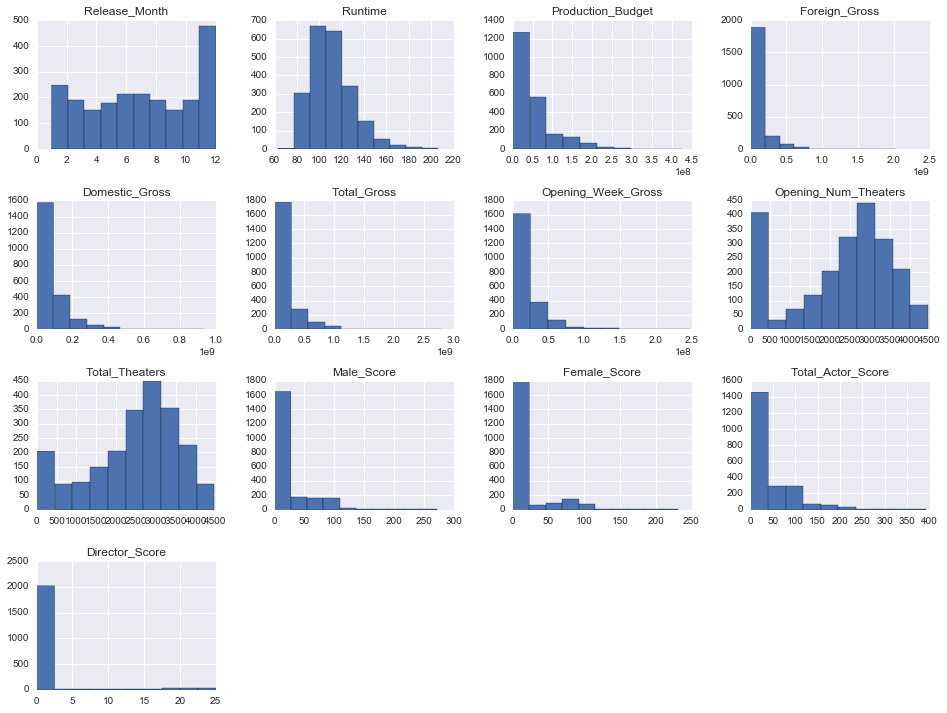

In [5]:
# A LOT OF SKEW AND POTENTIAL OUTLIERS
plt.figure(figsize = (16,12))
s = 1
for col in ['Release_Month', 'Runtime', 'Production_Budget',
 'Foreign_Gross', 'Domestic_Gross', 'Total_Gross', 'Opening_Week_Gross', 
 'Opening_Num_Theaters', 'Total_Theaters', 'Male_Score', 'Female_Score', 'Total_Actor_Score', 'Director_Score']:
    plt.subplot(4,4,s)
    plt.hist(movie_df[col])
    plt.title(col)
    s+=1

plt.subplots_adjust(hspace = 0.4, wspace = 0.33)

plt.savefig('first_glance.png', dpi = 200, facecolor = '0.77')

### EXAMINE RELATIONSHIPS BETWEEN FEATURES AND TARGET

#### And Collect Outliers

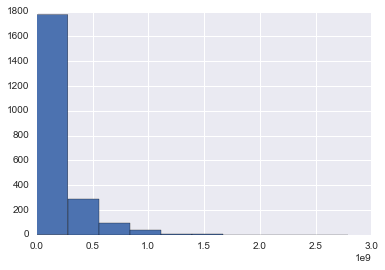

In [13]:
target = movie_df.Total_Gross
# because this is so right skewed, I'm going to also try to predict log_gross
plt.hist(target)
#plt.title('Distribution of Movie Gross', fontsize = 32, y = 1.05);
plt.savefig('target_hist.png', dpi = 200, facecolor = '0.77')

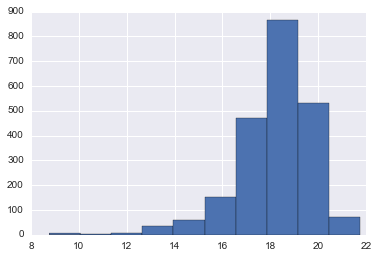

In [9]:
log_target = np.log(target)

plt.hist(log_target) # much better, and now it's even flipping me off! 
plt.savefig('logTarget_hist.png', dpi = 200, facecolor = '0.77')
outliers = []

To start... what's up with all those movies being released in December...

#### Release Month

Greater than 2Bil:
838                           Avatar
861     Star Wars: The Force Awakens
1415                         Titanic
Name: Title, dtype: object

June Baby:
375    Jurassic World
Name: Title, dtype: object

April Outlier:
266    Furious 7
Name: Title, dtype: object


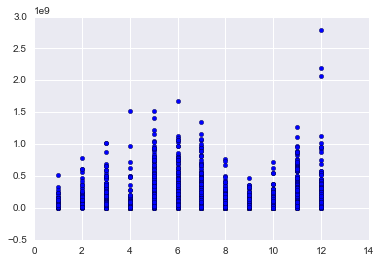

In [15]:
# That's weird... looks like Starwars, Avatar, and Titatnic were all released in December
plt.scatter(movie_df.Release_Month, target)

print "Greater than 2Bil:\n", movie_df[movie_df.Total_Gross>2000000000].Title
outliers.extend(movie_df[movie_df.Total_Gross>2000000000].Title.values)
print
print 'June Baby:\n',movie_df[(movie_df.Release_Month == 6) & (movie_df.Total_Gross > 1500000000)].Title

outliers.extend(movie_df[(movie_df.Release_Month == 6) & (movie_df.Total_Gross > 1500000000)].Title.values)
print

print 'April Outlier:\n', movie_df[(movie_df.Release_Month == 4) & (movie_df.Total_Gross > 1500000000)].Title
outliers.extend(movie_df[(movie_df.Release_Month == 4) & (movie_df.Total_Gross > 1500000000)].Title.values)
outliers.extend(movie_df[(movie_df.Release_Month == 6) & (movie_df.Total_Gross > 1500000000)].Title.values)

In [16]:
# Color Outliers
movie_df['Color'] = 'blue'
movie_df.loc[movie_df.Title.isin(outliers), 'Color'] = 'coral'
movie_df.Color.unique()

array(['blue', 'coral'], dtype=object)

#### Runtime

Runtime Skew 1.05033131459
Log Runtime Skew: 0.522719877242


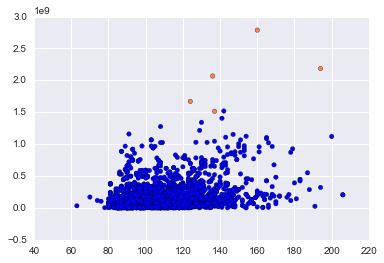

In [17]:
# FOR RUNTIME I ALREADY GOT THOSE OUTLIERS BUT MAYBE I CAN DO SOMETHING ABOUT THE SKEW
plt.scatter(movie_df.Runtime, target, c = movie_df.Color)
print 'Runtime Skew', movie_df.Runtime.skew()
print 'Log Runtime Skew:', np.log(movie_df.Runtime).skew()

movie_df['Log_Runtime'] = movie_df.Runtime.map(np.log)

#### Opening Num Theaters

Looks like a strangely skewed distribution for Opening Num Theaters

285 movies opened in less than 20 Theaters!

[u'Mission: Impossible - Ghost Protocol' u'Frozen' u'Star Wars'
 u'The Lion King']


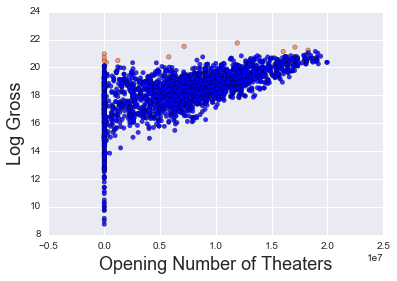

In [31]:
# Movies that oppened in less than 20 theaters
movie_df[movie_df.Opening_Num_Theaters <20].Title.nunique() # 285 movies opened in less than 20 theaters!



plt.scatter(movie_df.Opening_Num_Theaters**2, log_target, alpha= 0.8, c = movie_df.Color)
plt.xlabel('Opening Number of Theaters', fontsize = 18)
plt.ylabel('Log Gross', fontsize=18)
plt.savefig('Num_Theaters.png', dpi = 200, facecolor = '0.77')

# those top 3 again... 

# This looks like a clear exponential trend, but I want to check out those 4 outliers on the left
print movie_df[(movie_df.Opening_Num_Theaters < 500) & (movie_df.Total_Gross>600000000)].Title.values
outliers.extend(movie_df[(movie_df.Opening_Num_Theaters < 500) & (movie_df.Total_Gross>600000000)].Title.values)
movie_df.loc[movie_df.Title.isin(outliers), 'Color'] = 'coral'


Because this looks like a trend to me I'm going to add a feature that is the opening_num_theaters to the 6th power

In [19]:
movie_df['Opening_Num_Theaters_6pwr'] = movie_df.Opening_Num_Theaters**6
print 'Opening_Num_Thtrs^6th vs Target:', np.corrcoef(movie_df.Opening_Num_Theaters_6pwr, target)

# and for log_target I'm going to add a square_num_thtrs ftr too
movie_df['Opening_Num_Theaters_sqr'] = movie_df.Opening_Num_Theaters**2
print 'Opening_Num_Theaters^2 vs Log_Target:', np.corrcoef(movie_df.Opening_Num_Theaters_sqr, log_target) 

Opening_Num_Thtrs^6th vs Target: [[ 1.          0.70561145]
 [ 0.70561145  1.        ]]
Opening_Num_Theaters^2 vs Log_Target: [[ 1.         0.6376287]
 [ 0.6376287  1.       ]]


In [21]:
print 'Opening_Num_Theaters^2 vs Log_Target:\n', np.corrcoef(movie_df.Opening_Num_Theaters_sqr, log_target) 

Opening_Num_Theaters^2 vs Log_Target:
[[ 1.         0.6376287]
 [ 0.6376287  1.       ]]


#### Total Num Theaters

376    Jurassic Park
Name: Title, dtype: object
1322                      Star Wars
1323    E.T.: The Extra-Terrestrial
Name: Title, dtype: object


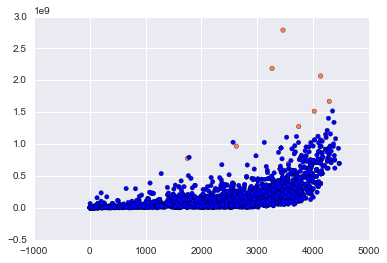

In [27]:
plt.scatter(movie_df.Total_Theaters, target, c = movie_df.Color)
print movie_df[(movie_df.Total_Theaters <3000) & (movie_df.Total_Gross>1000000000)].Title
print movie_df[(movie_df.Total_Theaters <2000) & (movie_df.Total_Gross>600000000)].Title

# Add Jurassic Park and E.T to Outliers
outliers.extend(movie_df[(movie_df.Total_Theaters <2000) & (movie_df.Total_Gross>600000000)].Title.values)
outliers.extend(movie_df[(movie_df.Total_Theaters <3000) & (movie_df.Total_Gross>1000000000)].Title.values)


In [19]:
movie_df.loc[movie_df.Title.isin(outliers), 'Color'] = 'coral'

In [20]:
# Same - create a new variable that is Total_Theaters to the 6th
print np.corrcoef(movie_df.Total_Theaters**6, target)

movie_df['Total_Theaters_6pwr'] = movie_df.Total_Theaters**6

[[ 1.          0.73254248]
 [ 0.73254248  1.        ]]


In [21]:
# Last thing I'm gonna add is a ratio of opening_theaters to total theaters
movie_df['Open_by_Total_Theaters'] = movie_df.Opening_Num_Theaters/movie_df.Total_Theaters

# slight correlation to log target
print np.corrcoef(movie_df.Open_by_Total_Theaters, log_target)

[[ 1.          0.32952402]
 [ 0.32952402  1.        ]]


#### Actor Score(s)

513    Avengers: Age of Ultron
862      Marvel's The Avengers
Name: Title, dtype: object


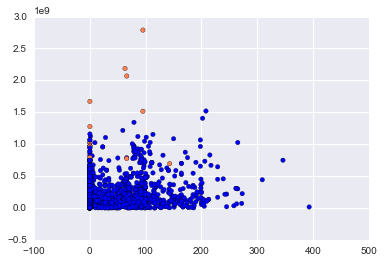

In [22]:
plt.scatter(movie_df.Total_Actor_Score, target, c = movie_df.Color)

# AVENGERS!
print movie_df[(movie_df.Total_Actor_Score>199) & (movie_df.Total_Gross>1250000000)].Title
outliers.extend(movie_df[(movie_df.Total_Actor_Score>199) & (movie_df.Total_Gross>1250000000)].Title.values)

movie_df.loc[movie_df.Title.isin(outliers), 'Color'] = 'coral'

So This is difficult. There Looks to be a negative trend here... but if I take the log of it i get a slightly positive looking correlation. Plus I deskew... a little.

In [23]:
# To do this i have to change all those 0s though - cuz can't take log of zero
movie_df.loc[movie_df.Total_Actor_Score==0, 'Total_Actor_Score'] = 0.1

1.75321500942
0.287891878861
[[ 1.          0.17086376]
 [ 0.17086376  1.        ]]


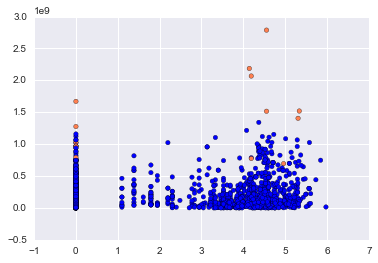

In [24]:
print movie_df.Total_Actor_Score.skew()
print np.log(movie_df.Total_Actor_Score).skew()
movie_df['Log_Actor_Score'] = np.log(movie_df.Total_Actor_Score)
movie_df.Log_Actor_Score.replace(np.log(0.1), 0, inplace=True)
plt.scatter(movie_df.Log_Actor_Score, target, c = movie_df.Color)
print np.corrcoef(movie_df.Log_Actor_Score, target)

# The weak correlation is because of all the movies with no actor score... how do I handle??

#### Director Score

In [38]:
movie_df.Color = 'navy'
movie_df.loc[movie_df.Directors.map(lambda lst: 'Peter Jackson' in lst), 'Color'] = 'coral'

array([[ 1.        ,  0.13940475],
       [ 0.13940475,  1.        ]])

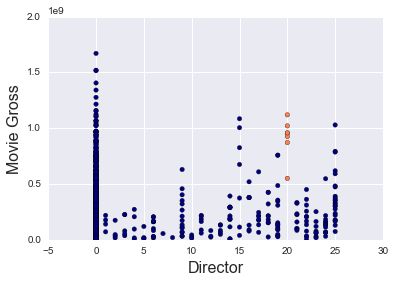

In [42]:
plt.scatter(movie_df.Director_Score, target, c = movie_df.Color)
plt.xlabel('Director', fontsize = 16)
plt.ylabel('Movie Gross', fontsize =16)
plt.ylim(0,2000000000)
plt.savefig('Director.png', dpi = 200, facecolor = '0.77')

np.corrcoef((movie_df.Director_Score), target)

# Again this whole thing is thrown off by all those Zeros! wtf

# However there is one thing I'd look at and that's all those movies with a director score of 20... what is that?

In [26]:
# PETER JACKSON
# NEVER MADE A BAD MOVIE (Anyone who says Dead-Alive is a bad Movie - GET OUT NOW!)
movie_df[movie_df.Director_Score == 20].Title.unique()

array([u'King Kong', u'The Hobbit: An Unexpected Journey',
       u'The Hobbit: The Battle of the Five Armies',
       u'The Lord of the Rings: The Return of the King',
       u'The Lord of the Rings: The Two Towers',
       u'The Lord of the Rings: The Fellowship of the Ring',
       u'The Hobbit: The Desolation of Smaug'], dtype=object)

I'm gonna add genre dummies and make a full df so we can run some models!

In [108]:
# ADD GNR DUMMIES BEFORE YOU START DROPPING
print movie_df.shape
print gnr_dummies.shape

new_full = pd.concat([movie_df, gnr_dummies], axis =1)
print new_full.shape

(2209, 25)
(2209, 19)
(2209, 44)


In [110]:
outliers = list(set(outliers)) # I prob added some titles more than once
print len(outliers), 'Outliers \n'
print outliers 

# Indices to drop:
drop_idxs = new_full[new_full.Title.isin(outliers)].index



13 Outliers 

[u'Star Wars', u'The Lion King', u'Star Wars: The Force Awakens', u"Marvel's The Avengers", u'Frozen', u'Furious 7', u'Titanic', u'Avengers: Age of Ultron', u'E.T.: The Extra-Terrestrial', u'Avatar', u'Mission: Impossible - Ghost Protocol', u'Jurassic World', u'Jurassic Park']


In [109]:
# SAVE NEW FULL

with open('Pickle_Files/new_full.pkl','wb') as f:
    pickle.dump(new_full, f, -1)